# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

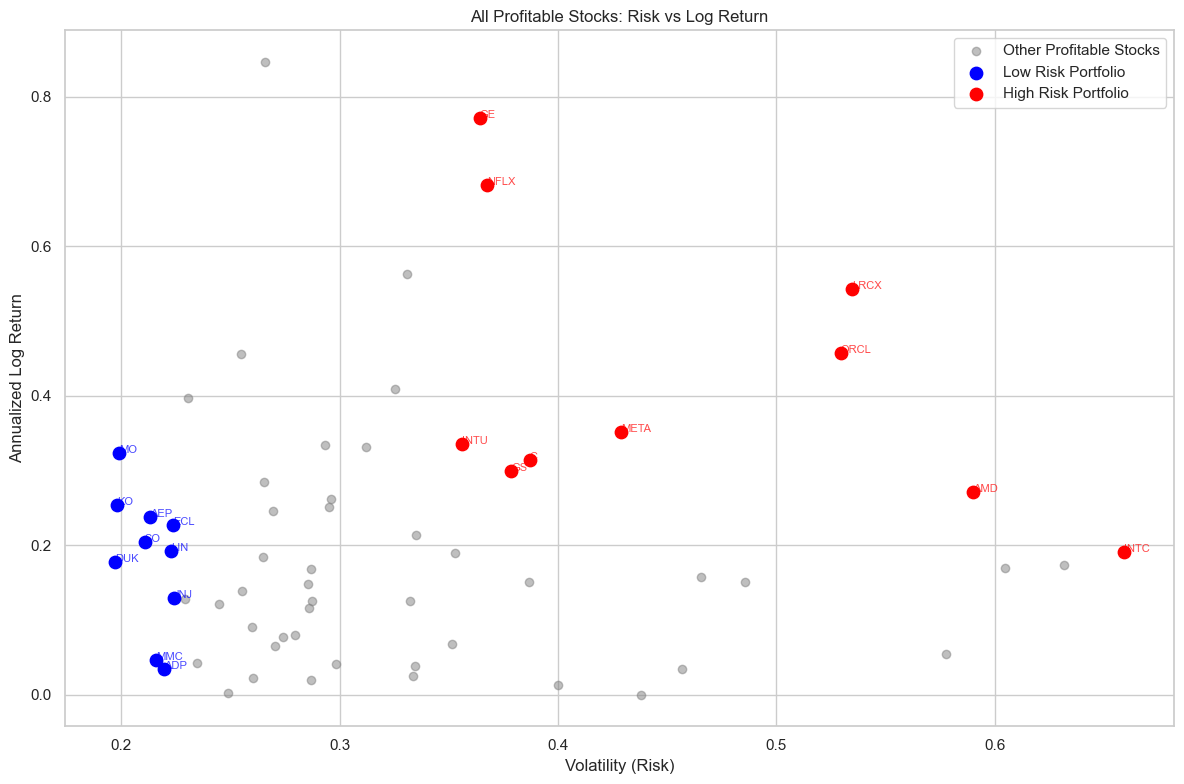

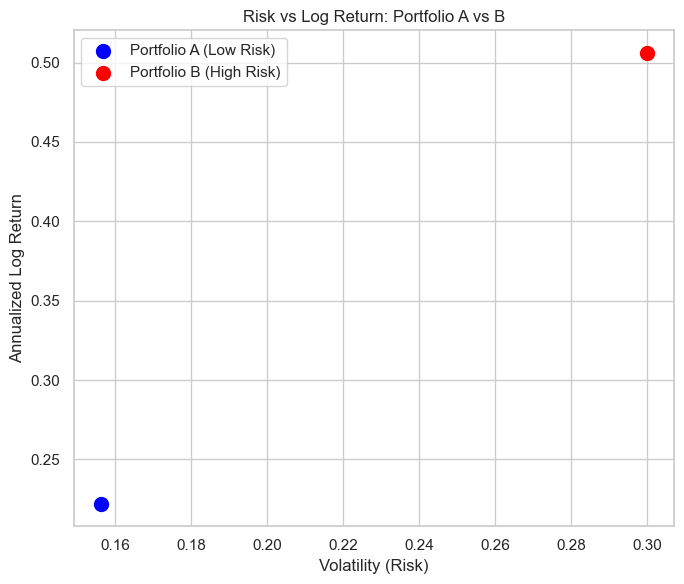

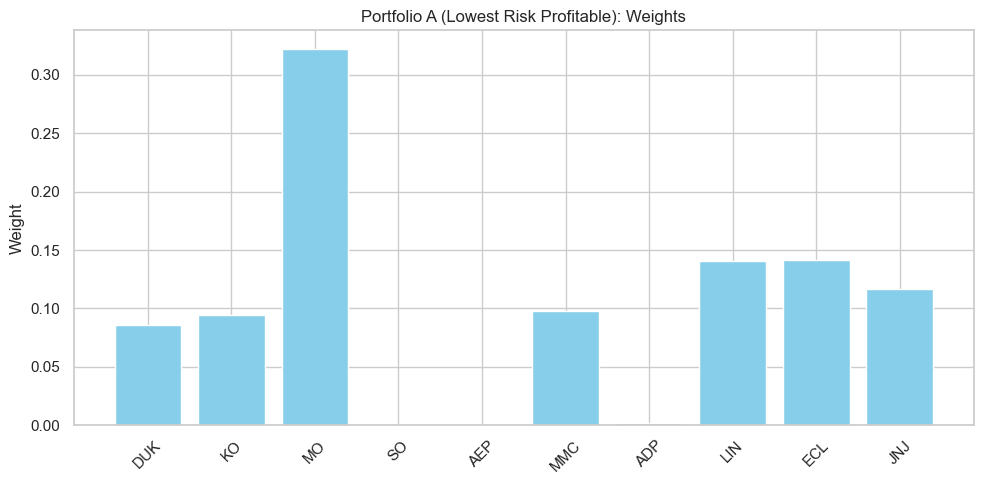

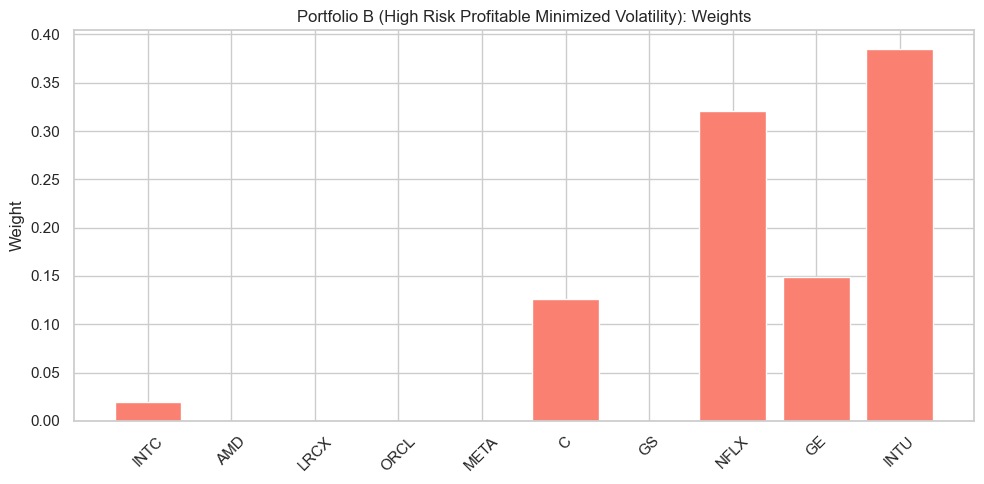


 Portfolio A (Low Risk) Summary
------------------------------
Stocks: DUK, KO, MO, SO, AEP, MMC, ADP, LIN, ECL, JNJ
Weighted Log Return: 22.22%
Weighted Volatility: 15.63%

Weights:
  DUK: 8.54%
  KO: 9.45%
  MO: 32.19%
  SO: 0.00%
  AEP: 0.00%
  MMC: 9.75%
  ADP: 0.18%
  LIN: 14.04%
  ECL: 14.18%
  JNJ: 11.67%
----------------------------------------

 Portfolio B (High Risk) Summary
-------------------------------
Stocks: INTC, AMD, LRCX, ORCL, META, C, GS, NFLX, GE, INTU
Weighted Log Return: 50.61%
Weighted Volatility: 29.99%

Weights:
  INTC: 1.96%
  AMD: 0.00%
  LRCX: 0.00%
  ORCL: 0.00%
  META: 0.00%
  C: 12.62%
  GS: 0.00%
  NFLX: 32.05%
  GE: 14.89%
  INTU: 38.49%
----------------------------------------


In [126]:


# Importing required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Defining 100 diverse tickers
TICKERS = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'BRK-B', 'UNH', 'JPM',
    'V', 'JNJ', 'WMT', 'PG', 'MA', 'HD', 'PFE', 'ABBV', 'MRK', 'PEP',
    'KO', 'AVGO', 'CVX', 'LLY', 'XOM', 'COST', 'BAC', 'ABT', 'MCD', 'TMO',
    'ORCL', 'ACN', 'CSCO', 'DHR', 'INTC', 'NFLX', 'TXN', 'WFC', 'NEE', 'LIN',
    'AMD', 'PM', 'UNP', 'BMY', 'UPS', 'LOW', 'RTX', 'SBUX', 'IBM', 'QCOM',
    'GS', 'BLK', 'CAT', 'GE', 'AMGN', 'PLD', 'ADI', 'INTU', 'MDT', 'ISRG',
    'CB', 'SPGI', 'SYK', 'USB', 'ZTS', 'VRTX', 'CI', 'LRCX', 'MMC', 'CL',
    'APD', 'REGN', 'GM', 'EL', 'DE', 'T', 'MO', 'ADP', 'PNC', 'BDX',
    'EW', 'ETN', 'SO', 'DUK', 'AEP', 'ECL', 'AFL', 'FIS', 'GILD', 'C',
    'ROST', 'F', 'PSA', 'TFC', 'EMR', 'HUM', 'KMB', 'STZ', 'ADSK', 'MS'
]

# Downloading data
data = yf.download(TICKERS, period="6mo", auto_adjust=True, progress=False)

# Extracting adjusted close prices
if 'Adj Close' in data.columns:
    prices = data['Adj Close']
elif 'Close' in data.columns:
    prices = data['Close']
else:
    try:
        prices = data.xs('Adj Close', axis=1, level=0)
    except:
        raise ValueError(" 'Adj Close' or 'Close' not found in data.")

# Dropping tickers with all-NaN values
prices = prices.dropna(axis=1, how='all')

# Daily log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Annualized metrics
mean_log_returns = log_returns.mean() * 252
volatility = log_returns.std() * np.sqrt(252)

metrics = pd.DataFrame({
    'Log Return': mean_log_returns,
    'Volatility': volatility
})

# Selecting profitable stocks
profitable = metrics[metrics['Log Return'] > 0]

# Portfolio A: lowest risk among profitable stocks
portfolio_A = profitable.sort_values('Volatility').head(10)
n_stocks = len(portfolio_A)
portfolio_A_return = portfolio_A['Log Return'].mean()

# Portfolio B: high risk, high return stocks
portfolio_B_candidates = profitable.sort_values('Volatility', ascending=False)
high_return_candidates = portfolio_B_candidates[portfolio_B_candidates['Log Return'] > portfolio_A_return]

if len(high_return_candidates) >= n_stocks:
    portfolio_B = high_return_candidates.head(n_stocks)
else:
    print(f" Only {len(high_return_candidates)} high-return candidates found.")
    needed = n_stocks - len(high_return_candidates)
    filler = portfolio_B_candidates.loc[~portfolio_B_candidates.index.isin(high_return_candidates.index)].head(needed)
    portfolio_B = pd.concat([high_return_candidates, filler])

# Optimization helper functions
def port_vol(w, cov): return np.sqrt(w.T @ cov @ w)
def port_ret(w, mu): return w @ mu

# Minimizing volatility of Portfolio A
returns_A = log_returns[portfolio_A.index]
cov_A = returns_A.cov() * 252
mu_A = mean_log_returns[portfolio_A.index]
init_w_A = np.ones(n_stocks) / n_stocks
bounds_A = [(0, 1)] * n_stocks
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
opt_A = minimize(port_vol, init_w_A, args=(cov_A,), bounds=bounds_A, constraints=cons)
weights_A = opt_A.x
portfolio_A['Weight'] = weights_A

# Final metrics for A
total_ret_A = port_ret(weights_A, mu_A)
total_vol_A = port_vol(weights_A, cov_A)

# Minimizing volatility for Portfolio B
returns_B = log_returns[portfolio_B.index]
cov_B = returns_B.cov() * 252
mu_B = mean_log_returns[portfolio_B.index]
init_w_B = np.ones(n_stocks) / n_stocks
bounds_B = [(0, 1)] * n_stocks
opt_B = minimize(port_vol, init_w_B, args=(cov_B,), bounds=bounds_B, constraints=cons)
weights_B = opt_B.x
portfolio_B = portfolio_B.copy()
portfolio_B['Weight'] = weights_B

# Final metrics for B
total_ret_B = port_ret(weights_B, mu_B)
total_vol_B = port_vol(weights_B, cov_B)

# Scatter Plot of All Underlying Stocks by Risk Category
plt.figure(figsize=(12, 8))

# Plot of all profitable stocks
low_risk_stocks = profitable.loc[portfolio_A.index]
high_risk_stocks = profitable.loc[portfolio_B.index]

plt.scatter(profitable['Volatility'], profitable['Log Return'], color='gray', alpha=0.5, label='Other Profitable Stocks')
plt.scatter(low_risk_stocks['Volatility'], low_risk_stocks['Log Return'], color='blue', s=80, label='Low Risk Portfolio')
plt.scatter(high_risk_stocks['Volatility'], high_risk_stocks['Log Return'], color='red', s=80, label='High Risk Portfolio')

# Annotating stock tickers
for ticker in low_risk_stocks.index:
    x, y = low_risk_stocks.loc[ticker, ['Volatility', 'Log Return']]
    plt.text(x, y, ticker, fontsize=8, color='blue', alpha=0.7)
for ticker in high_risk_stocks.index:
    x, y = high_risk_stocks.loc[ticker, ['Volatility', 'Log Return']]
    plt.text(x, y, ticker, fontsize=8, color='red', alpha=0.7)

plt.title('All Profitable Stocks: Risk vs Log Return')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Annualized Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined Scatter Plot for Portfolio Comparison
plt.figure(figsize=(7, 6))
plt.scatter(total_vol_A, total_ret_A, color='blue', label='Portfolio A (Low Risk)', s=100)
plt.scatter(total_vol_B, total_ret_B, color='red', label='Portfolio B (High Risk)', s=100)
plt.title('Risk vs Log Return: Portfolio A vs B')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Annualized Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualizations
plt.figure(figsize=(10, 5))
plt.bar(portfolio_A.index, portfolio_A['Weight'], color='skyblue')
plt.title('Portfolio A (Lowest Risk Profitable): Weights')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(portfolio_B.index, portfolio_B['Weight'], color='salmon')
plt.title('Portfolio B (High Risk Profitable Minimized Volatility): Weights')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary Output
def print_portfolio_summary(name, portfolio_df, total_ret, total_vol):
    print(f"\n {name} Summary")
    print("-" * (len(name) + 8))
    print(f"Stocks: {', '.join(portfolio_df.index)}")
    print(f"Weighted Log Return: {total_ret:.2%}")
    print(f"Weighted Volatility: {total_vol:.2%}")
    print("\nWeights:")
    for ticker, weight in zip(portfolio_df.index, portfolio_df['Weight']):
        print(f"  {ticker}: {weight:.2%}")
    print("-" * 40)

# Display both portfolios
print_portfolio_summary("Portfolio A (Low Risk)", portfolio_A, total_ret_A, total_vol_A)
print_portfolio_summary("Portfolio B (High Risk)", portfolio_B, total_ret_B, total_vol_B)
